In [2]:
import os
import tensorflow as tf

# Define paths to training and testing datasets
path = os.getcwd()
TRAIN_PATH = os.path.join(path, 'archive/Train')
TEST_PATH = os.path.join(path, 'archive/Test-A')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 224
BATCH_SIZE = 32

data_gen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)


train_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='training',batch_size = BATCH_SIZE,shuffle = True,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='validation',batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = TEST_PATH,batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


In [ ]:
#CNN
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplt as plt
import numpy as np

In [5]:
initial_model_cnn = models.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, F1Score

initial_model_cnn.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy', 
    metrics=['accuracy', Precision(), Recall(), F1Score(average="micro")])
initial_model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,476,549 (196.37 MB)

 Trainable params: 51,476,549 (196.37 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history_cnn = initial_model_cnn.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    validation_data=valid_gen
)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7030 - f1_score: 0.4047 - loss: 1.2123 - precision: 0.7408 - recall: 0.6272 - val_accuracy: 0.7531 - val_f1_score: 0.3936 - val_loss: 0.7292 - val_precision: 0.7968 - val_recall: 0.7196
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 248s 972ms/step - accuracy: 0.8443 - f1_score: 0.6667 - loss: 0.4447 - precision: 0.8775 - recall: 0.8088 - val_accuracy: 0.8057 - val_f1_score: 0.5935 - val_loss: 0.5056 - val_precision: 0.8481 - val_recall: 0.7742
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 236s 924ms/step - accuracy: 0.8863 - f1_score: 0.7560 - loss: 0.3293 - precision: 0.9052 - recall: 0.8635 - val_accuracy: 0.8259 - val_f1_score: 0.7009 - val_loss: 0.4639 - val_precision: 0.8584 - val_recall: 0.7934
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.9113 - f1_score: 0.8067 - loss: 0.2593 - precision: 0.9247 - recall: 0.8987 - val_accuracy: 0.8003 - val_f1_score: 0.6765 - val_loss: 0.5531 - val_precision: 0.8266 - v

In [53]:
initial_cnn_metrics = initial_model_cnn.evaluate(test_gen, verbose=0)

In [54]:
initial_cnn_metrics

[0.20354750752449036,
 0.9267112016677856,
 0.9323851466178894,
 0.921640932559967,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.9772726 , 0.72186285, 0.960038  , 0.7657431 , 0.95411086],
       dtype=float32)>]

In [ ]:
def plot_curves(history, model_name):
    def plot_loss_curves(history, plot):
        plot.plot(history.history['loss'], label='Train Loss')
        plot.plot(history.history['val_loss'], label='Validation Loss')
        plot.set_title(f'{model_name}: Training & Validation Loss')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Mean Squared Error (Loss)')
        plot.legend()
        plot.grid(True)

    def plot_accuracy_curves(history, plot):
        plot.plot(history.history['accuracy'], label='Train Accuracy')
        plot.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plot.set_title(f'{model_name}: Training & Validation Accuracy')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Accuracy')
        plot.legend()
        plot.grid(True)

    def plot_precision_curves(history, plot):
        plot.plot(history.history['precision'], label='Train Precision')
        plot.plot(history.history['val_precision'], label='Validation Precision')
        plot.set_title(f'{model_name}: Training & Validation Precision')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Precision')
        plot.legend()
        plot.grid(True)

    def plot_recall_curves(history, plot):
        plot.plot(history.history['recall'], label='Train Recall')
        plot.plot(history.history['val_recall'], label='Validation Recall')
        plot.set_title(f'{model_name}: Training & Validation Recall')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Recall')
        plot.legend()
        plot.grid(True)
    
    
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    ax1, ax2, ax3, ax4= axes.flatten()
    plot_loss_curves(history, ax1)
    plot_accuracy_curves(history, ax2)
    plot_precision_curves(history, ax3)
    plot_recall_curves(history, ax4)
    plt.show()


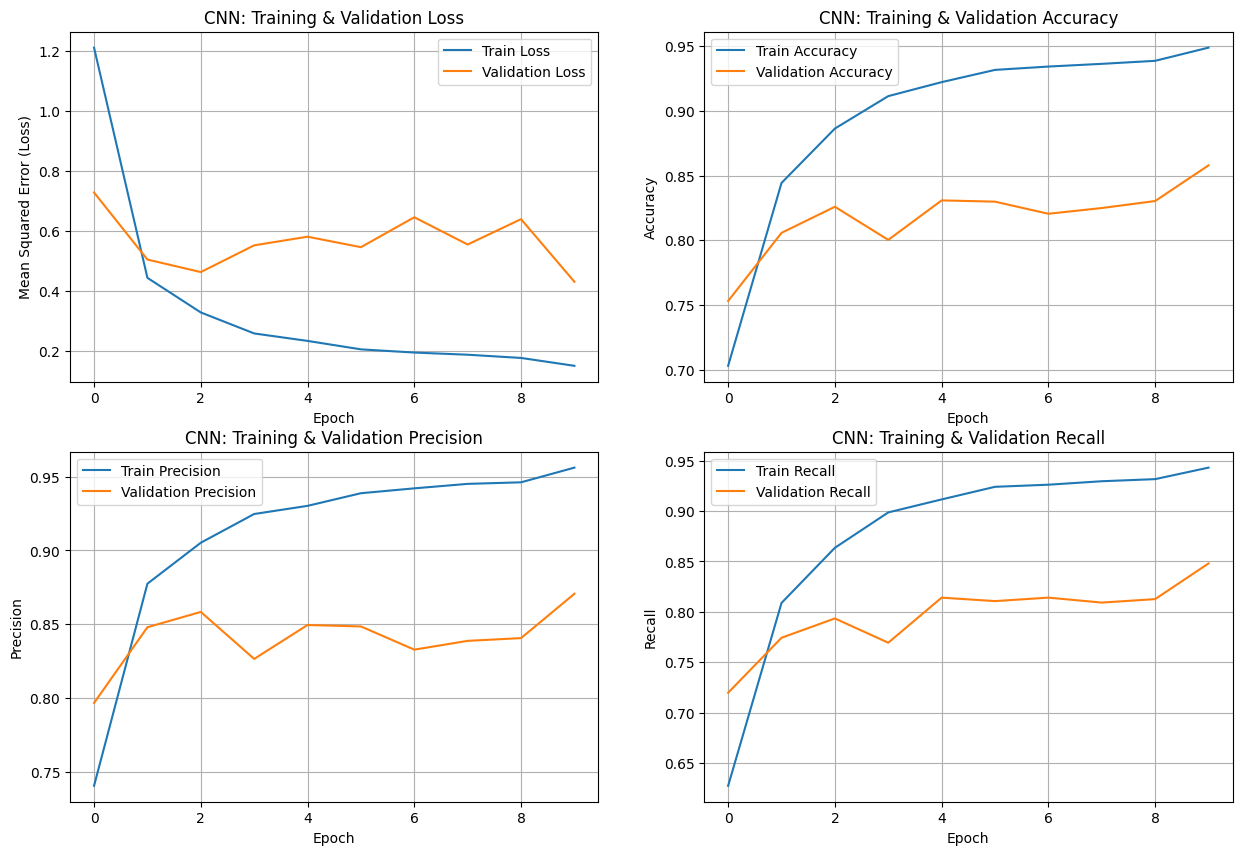

In [44]:
plot_curves(history_cnn, "CNN")

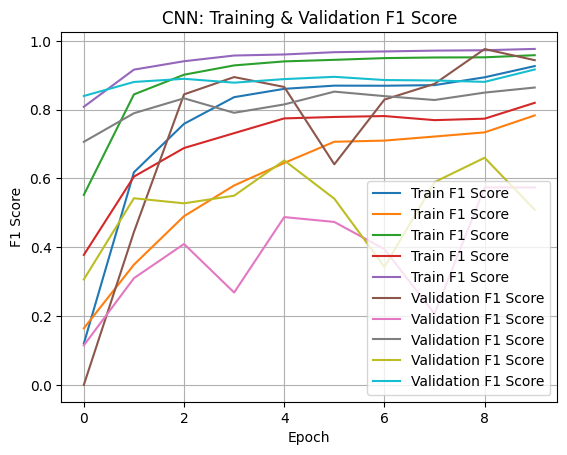

In [46]:
def plot_f1_curves(history, model_name):
    plt.plot(history.history['f1_score'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.title(f'{model_name}: Training & Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_curves(history_cnn, "CNN")


In [51]:
history_cnn.history['f1_score'][-1]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.9266862 , 0.78328973, 0.95832264, 0.8198894 , 0.9765483 ],
      dtype=float32)>

In [35]:
new_model_cnn = models.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
from tensorflow.keras.optimizers import Adam
new_model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])
new_model_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,477,445 (196.37 MB)

 Trainable params: 51,476,997 (196.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [37]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

classes = np.array([0,1,2,3,4])
y_train_labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_labels)
class_weight_dict = {i: min(w, 5) for i, w in enumerate(class_weights)}

new_history_cnn = new_model_cnn.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    validation_data=valid_gen,
    callbacks = [early_stopping, lr_scheduler],
    class_weight = class_weight_dict
)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.4435 - loss: 1.9364 - val_accuracy: 0.0207 - val_loss: 41.4560 - learning_rate: 1.0000e-04
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.6446 - loss: 0.7608 - val_accuracy: 0.3197 - val_loss: 5.9584 - learning_rate: 1.0000e-04
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.7514 - loss: 0.6061 - val_accuracy: 0.6026 - val_loss: 2.1050 - learning_rate: 1.0000e-04
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.8163 - loss: 0.4890 - val_accuracy: 0.6862 - val_loss: 1.2152 - learning_rate: 1.0000e-04
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.8365 - loss: 0.4251 - val_accuracy: 0.6886 - val_loss: 1.4290 - learning_rate: 1.0000e-04
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8578 - loss: 0.3692 - val_accuracy: 0.6754 - val_loss: 1.9704 - learning_rate: 1.0000e-04
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - ac

In [54]:
new_cnn_mse, _ = new_model_cnn.evaluate(test_gen, verbose=0)
print(f"Loss: {new_cnn_mse:.4f}")

Loss: 0.7156


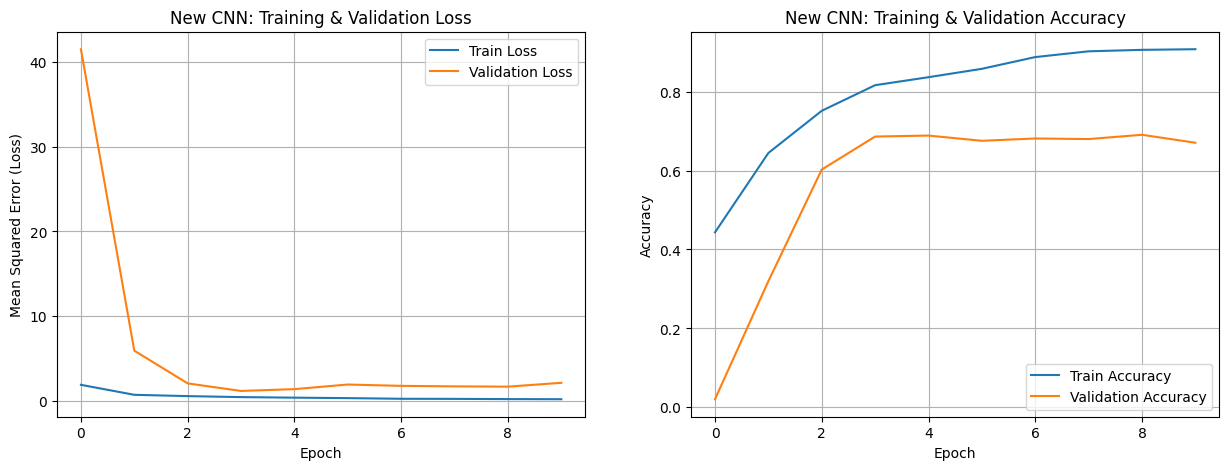

In [74]:
plot_curves(new_history_cnn)